In [611]:
from scipy.stats.qmc import LatinHypercube as LHSampler
from matplotlib import pyplot as plt
from typing import List, Tuple
import numpy as np
from math import floor
import random as r
import copy

In [413]:
LHS = LHSampler(d=2)

In [729]:
# 2D-only LHS plotter
def plotLHS(lhs: np.ndarray, grid = False, highlight = False):
    N, P = lhs.shape
    if P != 2:
        return
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.scatter(lhs[:, 0], lhs[:, 1], marker='o', c='r', s=2)
    if grid:
        for q in range(0, N):
            plt.axhline(y=q/N, color='black', linestyle='--', linewidth=0.3)
            plt.axvline(x=q/N, color='black', linestyle='--', linewidth=0.3)
    # floor(coord/interval_size) = interval_index (starting from zero)
    if highlight:
        timestep = 1/N
        for i in range(N):
            try:
                if lhs[i, 0] is None or lhs[i, 0] is None or np.isnan(lhs[i, 0]) or np.isnan(lhs[i, 1]):
                    continue
                qh = floor(lhs[i, 0]/timestep)
                qv = floor(lhs[i, 1]/timestep)
                plt.axvspan(qh/N, (qh+1)/N, facecolor='blue', alpha=0.15)
                plt.axhspan(qv/N, (qv+1)/N, facecolor='blue', alpha=0.15)
            except:
                continue


In [573]:
def lhs_grader(lhs: np.ndarray):
    y = sudoku_identity(lhs, verbose=False)
    # print([np.min(y[s]) for s in range(len(y))])
    # reducing y
    grade = np.min([np.sum(y[:, s]) for s in range(y.shape[1])])
    return grade

def sudoku_identity(lhs: np.ndarray, verbose: bool = False):
    N, P = lhs.shape
    y = np.zeros(lhs.shape, dtype=int)
    for q in range(N):
        interval = [q/N, (q+1)/N]
        for j in range(P):
            for i in range(N):
                if(lhs[i, j] is not None and not np.isnan(lhs[i, j]) and 
                   interval[0] <= lhs[i, j] <= interval[1]):
                    y[q, j] += int(1)
                    if not verbose:
                        break
    return y


# auxiliary h-bar matrix 
def lhs_grader_h(lhs: np.ndarray):
    y = sudoku_identity(lhs)
    # print([np.min(y[s]) for s in range(len(y))])
    # reducing y
    grade = np.min([np.sum(y[:, s, 0]) for s in range(y.shape[1])])
    return grade


def sudoku_identity_h(lhs: np.array):
    N, P = lhs.shape
    y = np.zeros((*lhs.shape, 2), dtype=int)
    # y = [[0 for _ in range(len(lhs))] for i in range(len(lhs))]
    for q in range(N):  # find another way out pls
        interval = [q/N, (q+1)/N]
        for j in range(P):
            y[q, j, 1] = -1
            for i in range(N):
                if(lhs[i, j] is not None and interval[0] <= lhs[i, j] <= interval[1]):
                    y[q, j, 0], y[q, j, 1] = int(1), i
                    break
    return y

In [416]:
# PeLHS (Partial expanded LHS)

def eLHS(lhs: np.ndarray, M:int):
    N, P = lhs.shape

    if(lhs_grader(lhs) == N):
        raise ValueError("Parameter lhs must be a proper LHS sample")
    

    exp = {"N": N,
           "M": M,
           "F": None,
           "Q": None,
           "expansion": np.array([]), 
           "grade": None }

    

ss1 = LHS.random(100)
# ss1[2] = ss1[3] + ss1[1] # interesting test
# print(ss1[2])
# print(sudoku_identity(ss1))
lhs_grader(ss1)



100

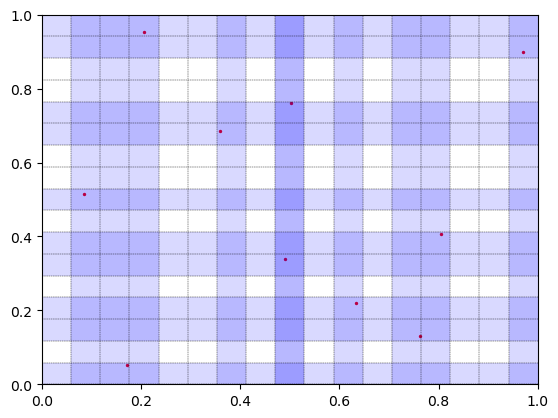

In [735]:
# tick for PeLHS vacancies 
def PartialeLHS(lhs: np.ndarray, M:int):
    _, P = lhs.shape
    PeLHS = np.concatenate((lhs, np.array([[None for _ in range(P)] for _ in range(M)])))
    return PeLHS
    

# could be interesting which distribution the PeLHS grade has while varying M and N
N, M = 10, 7
ss2 = LHS.random(N)
pss2 = PartialeLHS(ss2, M)
plotLHS(pss2, grid=True, highlight=True)

In [624]:
def inner_coords(point, N):
    timestep = 1/N
    # increases rounding error
    return [ point[j] * N - floor(point[j]/timestep) for j in range(len(point))]


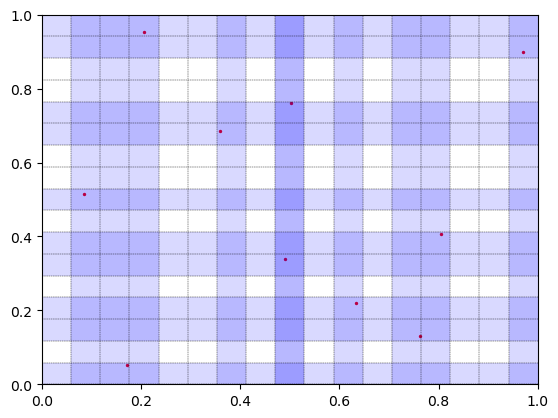

In [741]:
def rpop(v: np.ndarray):
    rindex = r.randint(0, len(v) - 1)
    return v[rindex], np.delete(v, rindex, 0)

def fill_the_gaps(pelhs: np.ndarray, M:int, scattering = False):
    PeLHS = copy.deepcopy(pelhs)
    N, P = PeLHS.shape[0] - M, PeLHS.shape[1]
    sdk = sudoku_identity(PeLHS)
    # list of available dim-vacancies in PeLHS
    # change vacancy array allocation to match a proper np matrix (do I need this?)
    vacancies = [[i for i in range(N + M) if sdk[i, j] == 0] for j in range(P)]
    # TODO: fill the vacancies with proper LHS samples (two cases: perfect expansion and degenerate expansion)
    # sub-LHS: an LHS where its intervals are mapped against the PeLHS empty intervals
    # but also
    # if(len([i for i in range(len(vacancies)) if len(vacancies[i]) != M]) == 0): 
    if(lhs_grader(PeLHS) == N):     # perfect expansion
        expansion = LHS.random(M)
        timestep = 1/(N+M)
        r.shuffle(expansion)
        for m in range(M):
            samplex = inner_coords(expansion[m], M)
            for j in range(P):
                q, vacancies[j] = rpop(vacancies[j])
                PeLHS[N + m, j] = (q + samplex[j]) * timestep
    return PeLHS

fss2 = fill_the_gaps(pss2, M)
plotLHS(fss2, True, True)

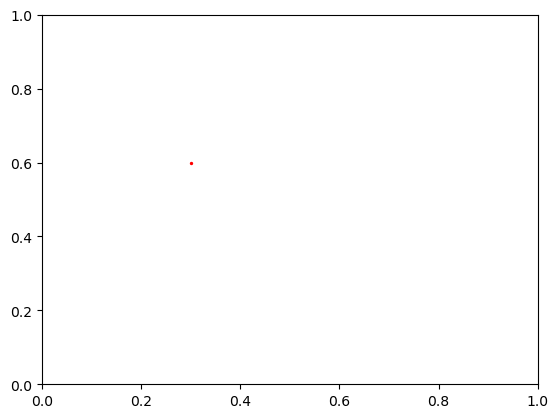

In [705]:
plotLHS(np.array([[0.3, 0.6]]), False, False)